In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image

from tqdm.notebook import tqdm
from scipy.io import loadmat
from utils_analysis import *
import torch
from torch.utils.data import DataLoader
import cv2
from skimage import data

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

CW2019で全てのbest headに含まれるうちでN2010のbest headが最も小さいものを探す．

In [3]:
training_methods = ["dino", "supervised"] 
depth_list = [8, 12]
num_models = 6
num_top = 5

imagenetの画像を256 x 256に変換．skimageの画像を付け足す．

In [4]:
image_labels = ["../dataset/popout/colors.png",
                "../dataset/popout/size.png",
                "../dataset/popout/alphabets.png",
                "../dataset/popout/orientation.png",
                "../dataset/popout/hatching.png"]
"""
image_labels = ["../dataset/popout/aaa.png","../dataset/popout/bbb.png"]
"""

# load frame
imgs = []
# imagenet
for path in image_labels:#imagenet_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape != (256, 256):
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    imgs.append(img)    
num_imgs = len(imgs)

In [5]:
attn_dict = np.load("../results/dino_vit_attention_groups_toy.npz", allow_pickle=True)

In [6]:
attn_concat = np.vstack([attn_dict[str(depth)].reshape(72, num_imgs, -1) for depth in depth_list])
attn_concat_flat = attn_concat.reshape(144, num_imgs, -1)

In [7]:
attn_concat_flat.shape

(144, 5, 256)

In [8]:
labels = np.load("../results/attn_best_label_N2010.npy")

In [9]:
np.unique(labels, return_counts=True)

(array([1, 2, 3], dtype=int32), array([24, 28, 92]))

In [10]:
attns = []
for i in range(1, 4):
    idx = np.where(labels == i)[0]
    attn = np.mean(attn_concat_flat[idx].reshape(-1, num_imgs, 16, 16), axis=0)
    attns.append(attn)

In [11]:
#attn_layer = attn_concat_flat[40].reshape(num_imgs, 16, 16)
attn_layer = attn_concat_flat[42].reshape(num_imgs, 16, 16)

In [12]:
label_convert = [1,3,2]

In [13]:
"""
plt.figure(figsize=(10,10))
for i in range(144):
    plt.subplot(12,12,i+1)
    plt.title(f"G{label_convert[labels[i]-1]}")
    plt.imshow(attn_concat_flat[i, 0].reshape(16, 16))
    plt.gca().axis("off")
plt.tight_layout()
"""

'\nplt.figure(figsize=(10,10))\nfor i in range(144):\n    plt.subplot(12,12,i+1)\n    plt.title(f"G{label_convert[labels[i]-1]}")\n    plt.imshow(attn_concat_flat[i, 0].reshape(16, 16))\n    plt.gca().axis("off")\nplt.tight_layout()\n'

In [14]:
attn_layer.shape

(5, 16, 16)

In [15]:
gbvs = loadmat("../dataset/popout/gbvs_map_popout.mat")

In [16]:
gbvs_attn = gbvs["gbvs_res"]

In [17]:
gbvs_idx = [1, 4, 0, 3, 2]

In [18]:
names = ["color", "size", "shape", "orientation", "hatching"]

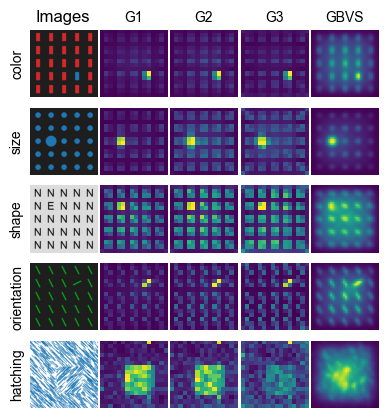

In [19]:
fig, axes = plt.subplots(num_imgs, 5, figsize=(4.5, 5))#, tight_layout=True)
for i in range(num_imgs):
    axes[i, 0].imshow(imgs[i])
    axes[i, 0].set_ylabel(names[i])
    #axes[i, 1].imshow(attn_layer[i])
    for jj, j in enumerate([0, 2, 1]):
        axes[i, 1+jj].imshow(attns[j][i])
    axes[i, 4].imshow(gbvs_attn[gbvs_idx[i]])
for i in range(num_imgs):
    for j in range(5):
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
axes[0, 0].set_title("Images")
for j in range(3):
    axes[0, 1+j].set_title(f"G{j+1}", fontsize=10)
axes[0, 4].set_title(f"GBVS", fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
#fig.suptitle(f"DINO ViT-{depth}, layer #{d_idx+1}, model #{m_idx+1}")
#plt.tight_layout()
fig.savefig(f"../figures/example_attention_maps_toydata.svg", dpi=300)